In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd

In [3]:
X = io.mmread("counts.mtx")

adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

cell_meta = pd.read_csv("metadata.csv")

/var/folders/dn/8p_n6qqs7n9cxm88lkk86yhw0000gn/T/ipykernel_1441/2952561868.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(


In [4]:
with open("gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

In [5]:
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [6]:
pca = pd.read_csv("pca.csv")
pca.index = adata.obs.index

In [7]:
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

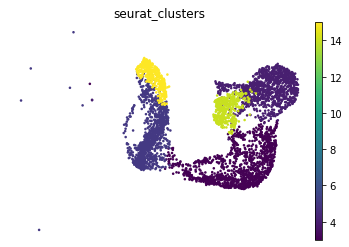

In [8]:
sc.pl.umap(adata, color=['seurat_clusters'], frameon=False, save=True)

In [9]:
import scvelo as scv
import cellrank as cr

In [10]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

In [11]:
ldata = scv.read('merged.loom', cache=True)
ldata

AnnData object with n_obs × n_vars = 18207 × 32285
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [19]:
index = ldata.obs.index
new_index = []
for i in range(len(index)):
    if "4700" in index[i]:
        new_index.append(index[i].replace('x','').replace('4700:','') + '-1')
    elif "4730" in index[i]:
        new_index.append(index[i].replace('x','').replace('4730:','') + '-2')
    elif "1966-1" in index[i]:
        new_index.append(index[i].replace('x','').replace('1966-1:','') + '-3')
    elif "1966-2" in index[i]:
        new_index.append(index[i].replace('x','').replace('1966-2:','') + '-4')
ldata.obs.index = new_index

In [22]:
ldata_HC_SC = ldata[cell_meta['barcode'].tolist()]

In [23]:
adata = scv.utils.merge(adata, ldata_HC_SC)

In [24]:
adata.obs['clusters'] = adata.obs['seurat_clusters']

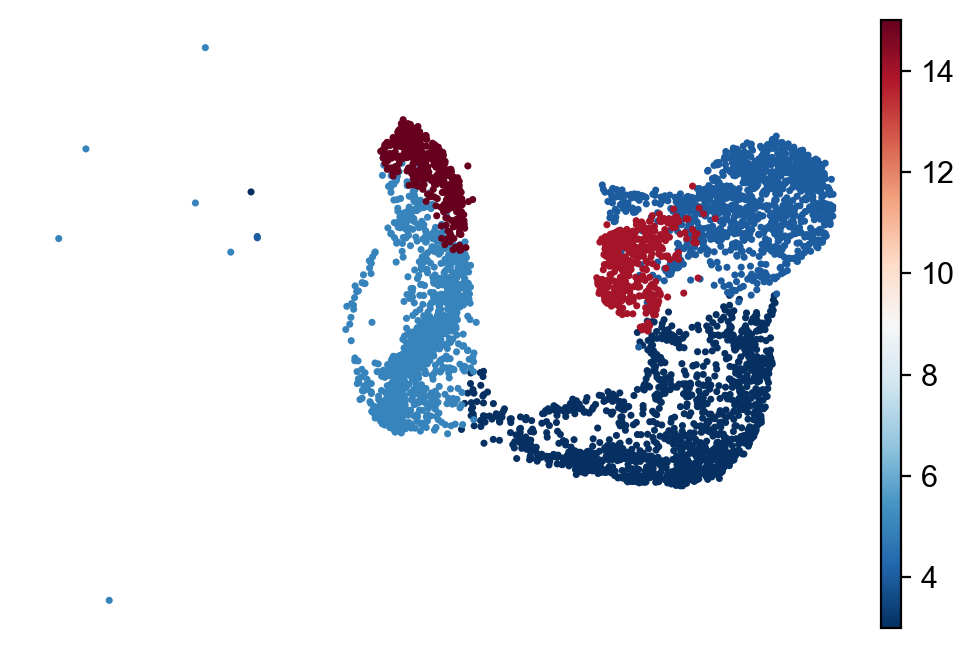

In [25]:
sc.pl.umap(adata, color='seurat_clusters', frameon=False, legend_loc='on data', title='', save='_celltypes.pdf')

In [26]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [27]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:22) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [28]:
scv.tl.velocity_graph(adata,basis='umap',n_jobs=6,sqrt_transform=True)

        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 6/8 cores)


  0%|          | 0/4610 [00:00<?, ?cells/s]

    finished (0:00:38) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_embedding_grid.png


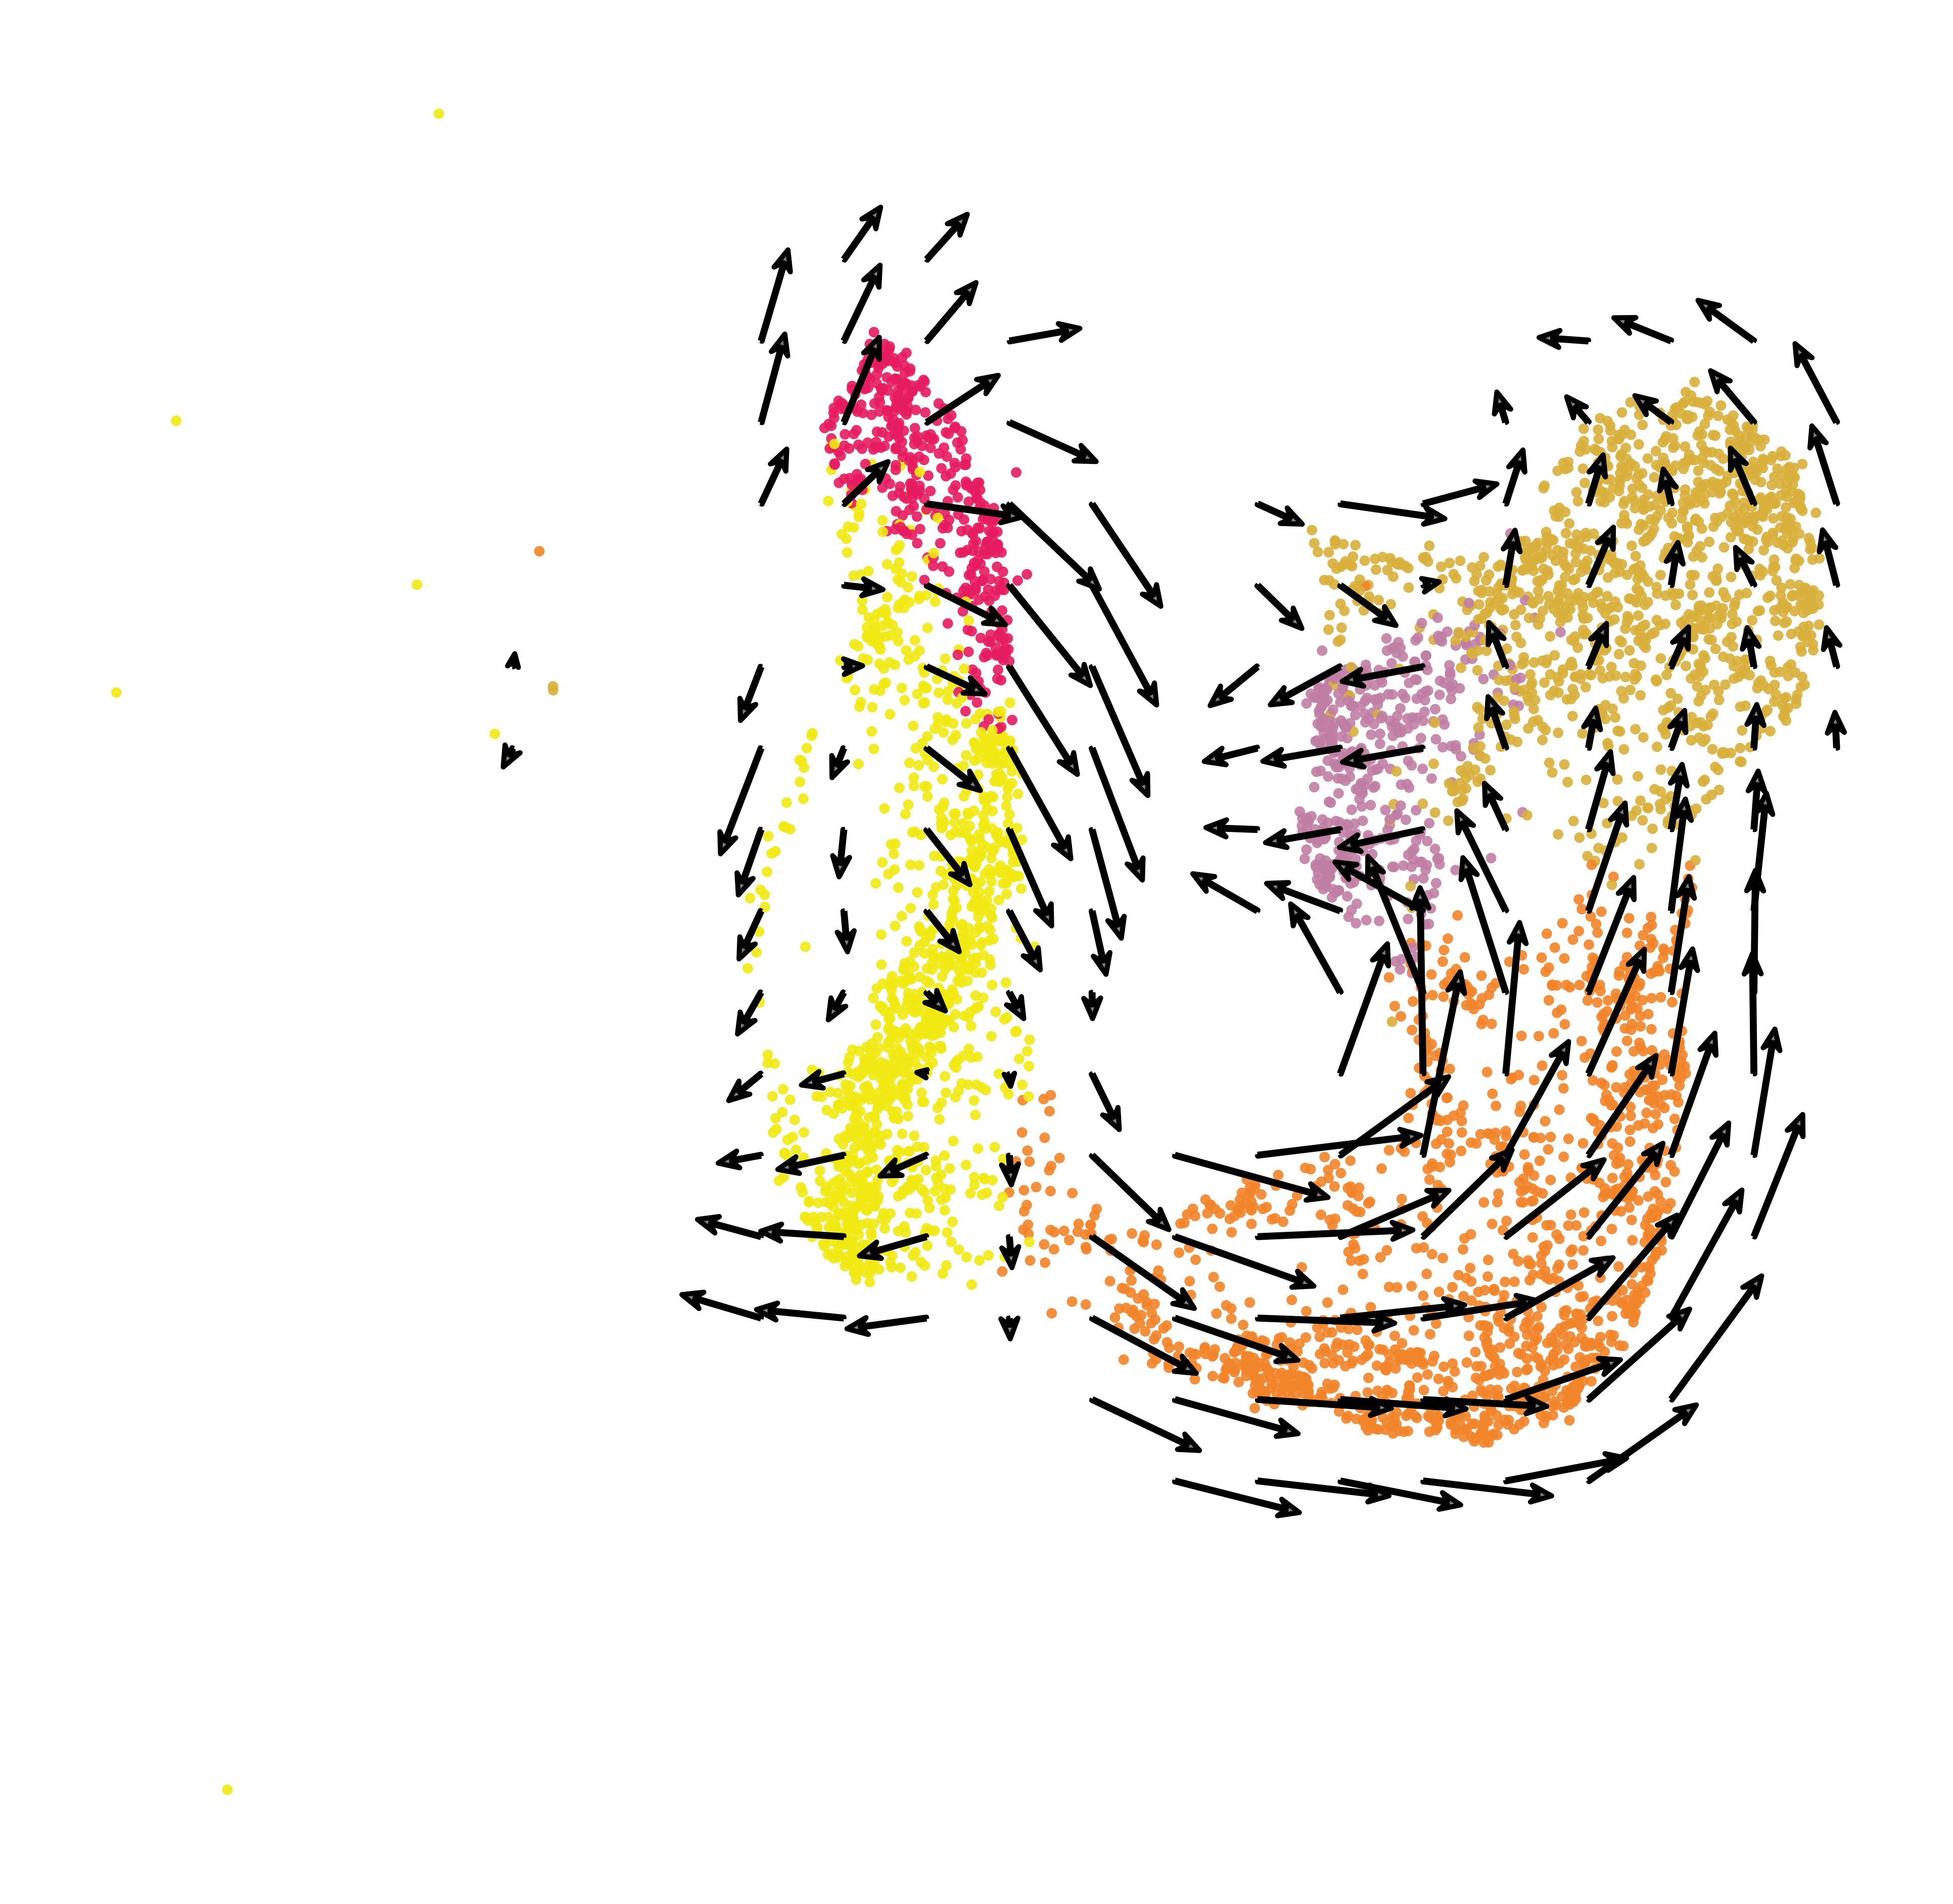

In [29]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='clusters', save='embedding_grid.png', title='', palette = ["#F28429","#D9B03B","#F1E911","#C17EA5","#E61B60"],\
                               scale=0.3, n_neighbors = 200, alpha = 0.9, size = 25, density = 0.45, dpi = 300, figsize = (8,8), arrow_size = 1.8, linewidth = 1.2)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_velocity.png


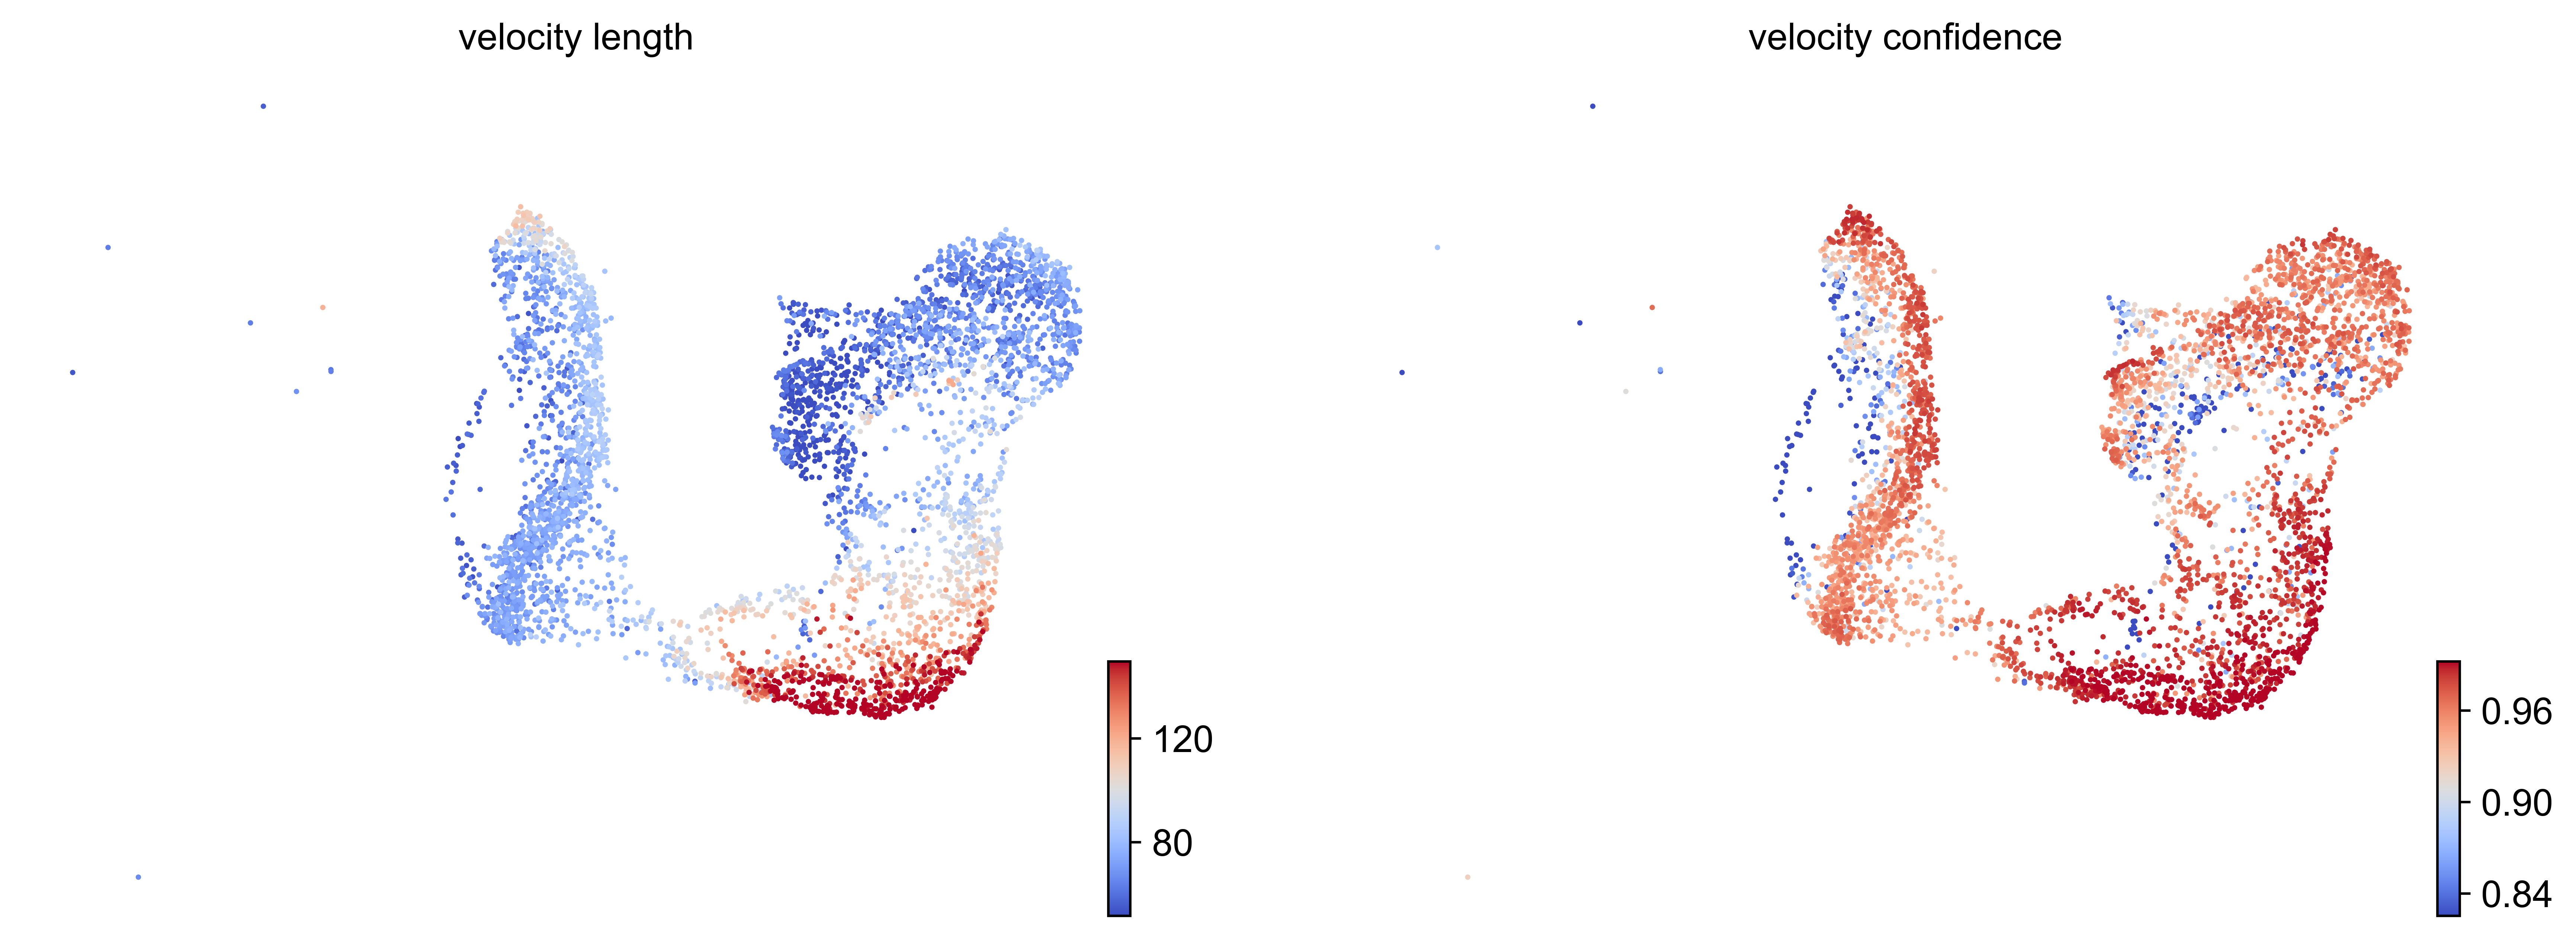

In [30]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95],figsize=(7,5), save='velocity.png', dpi = 300, size = 12)

computing terminal states
    identified 5 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file ./figures/scvelo_velocity_pseudotime.png


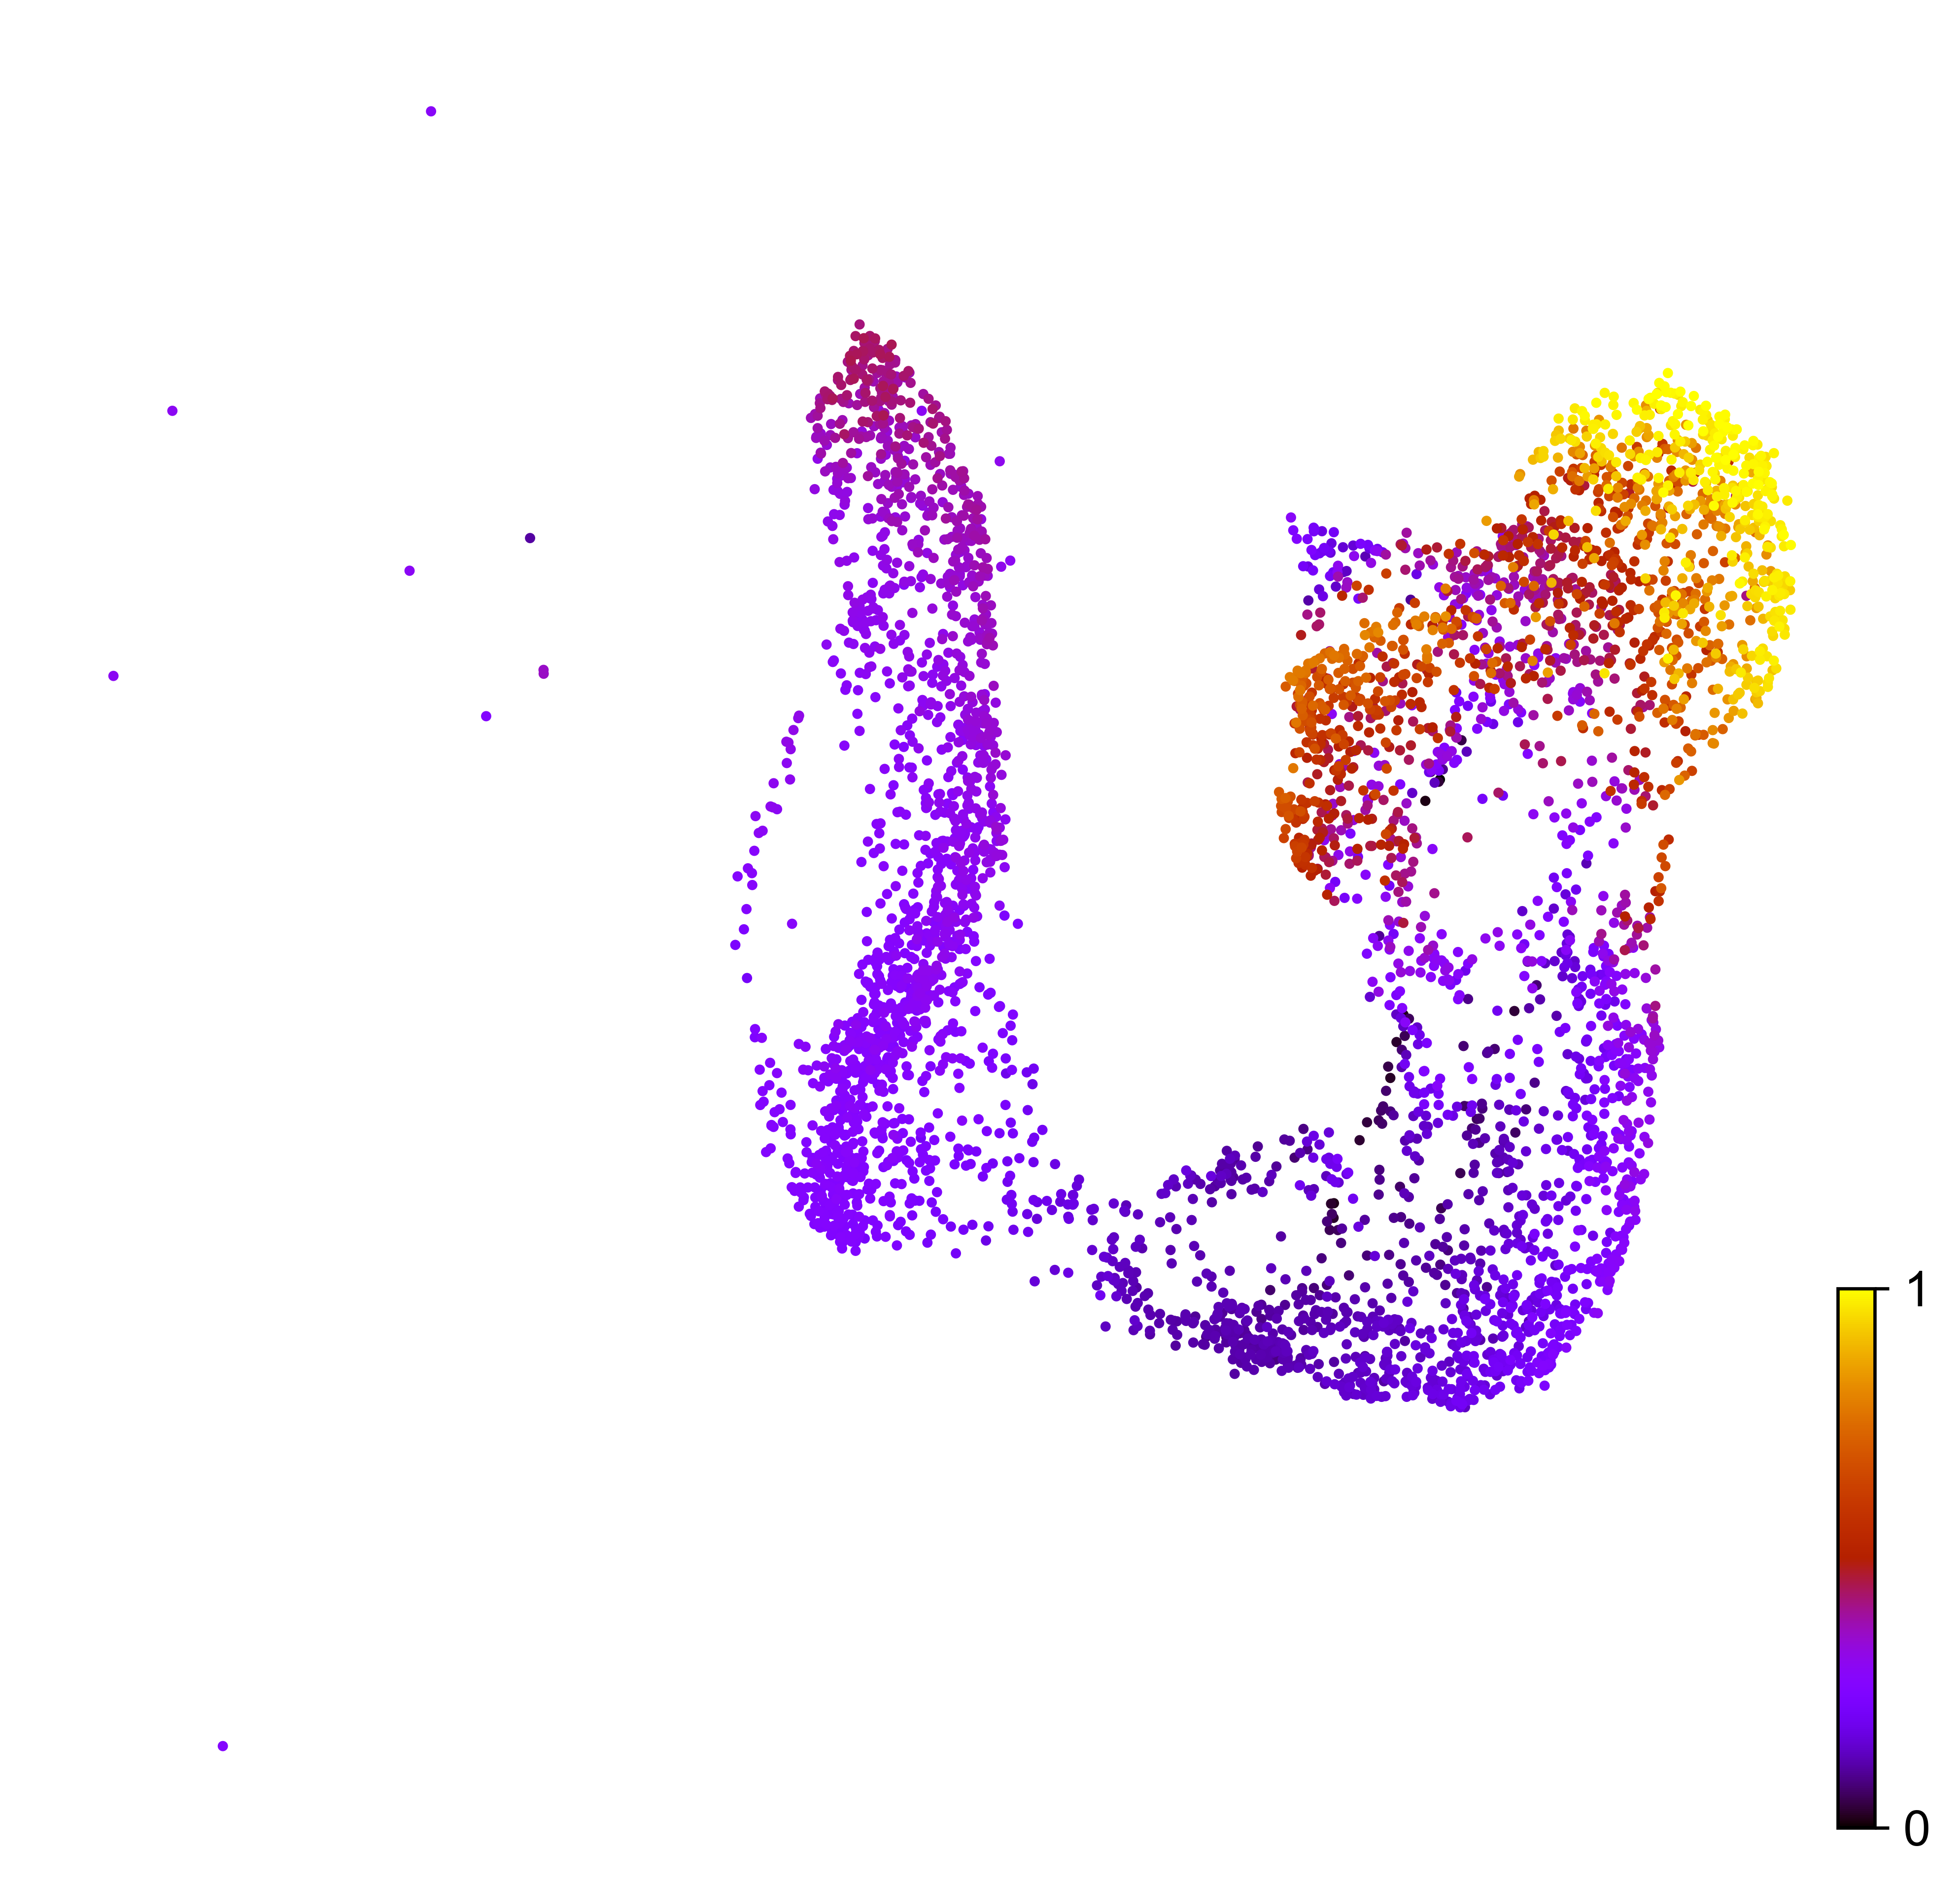

In [31]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot',figsize=(8,8), save='velocity_pseudotime.png', title='', dpi = 300, size = 25)